<a href="https://colab.research.google.com/github/tvgx/machinelearning/blob/main/Ai_emote_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/data

Data

In [1]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

In [3]:
train_df = pd.read_csv('/content/train_labels.csv')

label_counts = train_df['label'].value_counts()

# biểu đồ phân bố
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title('Distribution of Labels (Before Augmentation)')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/train_labels.csv'

Kích thước ảnh: 100x100


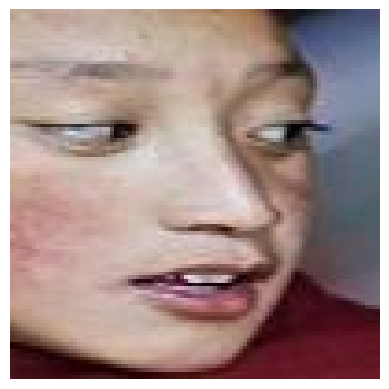

In [ ]:
# Size ảnh và 1 ví dụ
def show_image_and_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        print(f"Kích thước ảnh: {width}x{height}")

        plt.imshow(img)
        plt.axis('off')
        plt.show()

image_path = '/content/DATASET/test/1/test_0073_aligned.jpg'
show_image_and_size(image_path)


In [4]:
# Hiển thị ảnh và kích thước
def show_image_and_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        print(f"Kích thước ảnh gốc: {width}x{height}")

        plt.imshow(img)
        plt.axis('off')
        plt.show()

def show_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Không thể đọc ảnh!")
        return

    size = 100
    image = cv2.resize(image, (size, size))

    hog_features, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )

    print(f"Kích thước đặc trưng HOG: {hog_features.shape}")
    print(f"Kích thước ảnh HOG: {hog_image.shape}")

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("HOG Visualization")
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.axis('off')

    plt.show()

def show_examples_for_each_label(base_dir):
    print(f"\nHiển thị ví dụ ảnh từ tập: {base_dir}")
    for label_folder in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_folder)
        if not os.path.isdir(label_path):
            continue

        example_image = next((img for img in os.listdir(label_path) if img.endswith(('.jpg', '.png'))), None)
        if example_image is None:
            print(f"Không tìm thấy ảnh nào cho nhãn {label_folder}")
            continue

        example_image_path = os.path.join(label_path, example_image)
        print(f"\nLabel: {label_folder}")
        show_image_and_size(example_image_path)
        show_hog_features(example_image_path)

image_path = '/content/DATASET/test/1/test_0073_aligned.jpg'

print("Hiển thị thông tin ảnh cụ thể:")
show_image_and_size(image_path)
show_hog_features(image_path)

train_dir = './DATASET/train'
test_dir = './DATASET/test'

show_examples_for_each_label(train_dir)
show_examples_for_each_label(test_dir)


Hiển thị thông tin ảnh cụ thể:


FileNotFoundError: [Errno 2] No such file or directory: '/content/DATASET/test/1/test_0073_aligned.jpg'

In [ ]:
###Augmentation###

In [ ]:
train_dir = './DATASET/train'
test_dir = './DATASET/test'

size = 100

augmentation_rules = {
    7: ['flip'],
    5: [30, 'flip'],
    1: [15, 30, 'flip'],
    3: [5, 10, 15, 20,'flip'],
    6: [5, 10, 15, 20,'flip'],
    2: [5, 10, 15, 20, 25, 30, 45, 'flip']
}

def load_images_and_labels(base_dir, augment=False):
    images = []
    labels = []

    def rotate_image(image, angle):
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        return rotated

    def process_image(image, label, augment_rules):
        hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        images.append(hog_features)
        labels.append(label)

        if augment and augment_rules:
            for rule in augment_rules:
                if rule == 'flip':
                    flipped_image = cv2.flip(image, 1)
                    flipped_hog_features = hog(flipped_image, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
                    images.append(flipped_hog_features)
                    labels.append(label)
                elif isinstance(rule, (int, float)):
                    rotated_image = rotate_image(image, rule)
                    rotated_hog_features = hog(rotated_image, orientations=9, pixels_per_cell=(8, 8),
                                            cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
                    images.append(rotated_hog_features)
                    labels.append(label)


    for label_folder in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_folder)
        label = int(label_folder)

        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)

                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    continue

                image = cv2.resize(image, (size, size))

                process_image(image, label, augmentation_rules.get(label, []))

    return np.array(images), np.array(labels)

X_train, y_train = load_images_and_labels(train_dir, augment=True)
X_test, y_test = load_images_and_labels(test_dir, augment=False)



Hiển thị tất cả augmentation rules theo hàng ngang:


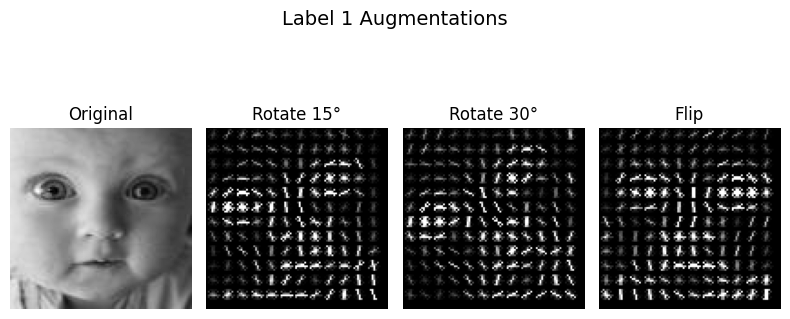

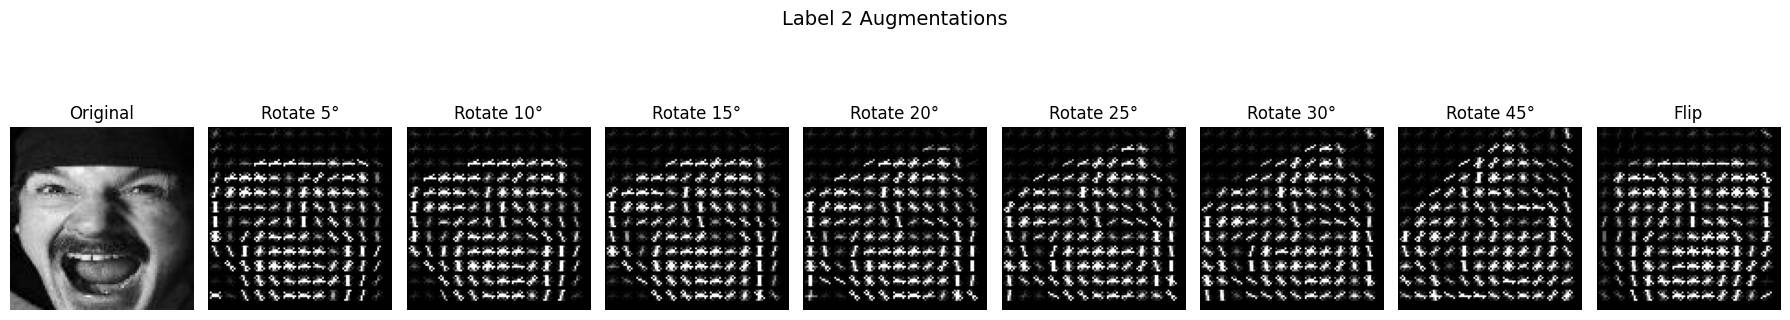

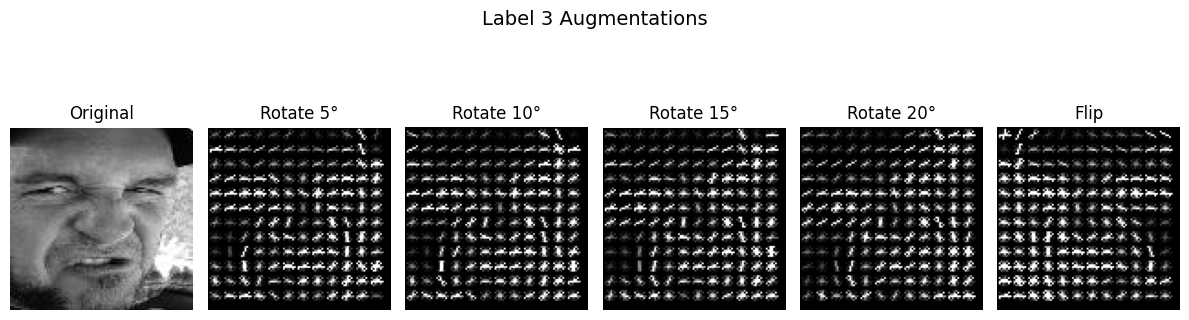

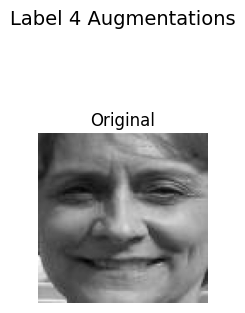

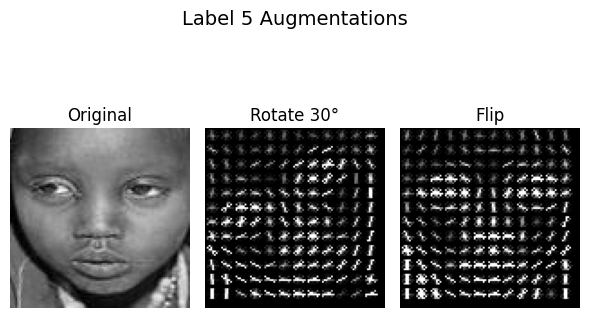

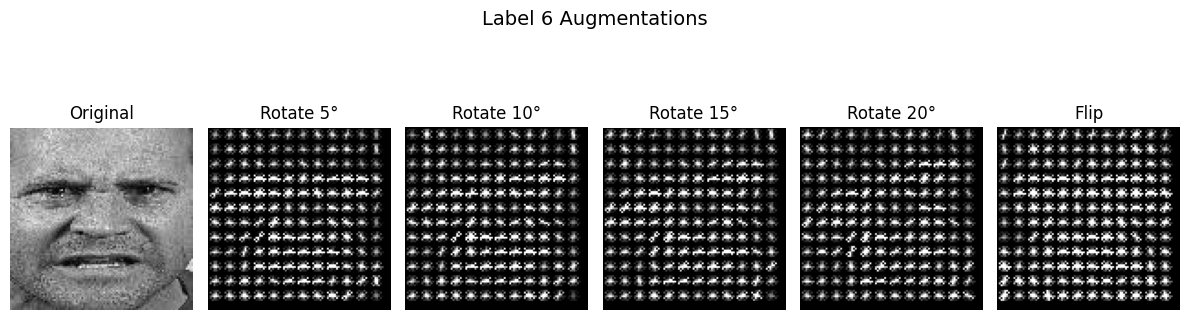

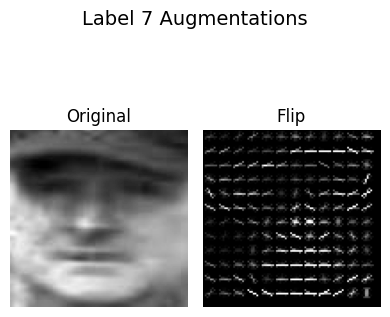

In [ ]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rotated

def show_hog(image):
    hog_features, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )
    return exposure.rescale_intensity(hog_image, in_range=(0, 10))

def show_full_augmentation_horizontal(base_dir, augmentation_rules):
    print("\nHiển thị tất cả augmentation rules theo hàng ngang:")
    for label_folder in sorted(os.listdir(base_dir)):
        label_path = os.path.join(base_dir, label_folder)
        if not os.path.isdir(label_path):
            continue

        example_image = next((img for img in os.listdir(label_path) if img.endswith(('.jpg', '.png'))), None)
        if not example_image:
            print(f"Không tìm thấy ảnh cho nhãn {label_folder}")
            continue

        example_image_path = os.path.join(label_path, example_image)
        image = cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Không thể đọc ảnh {example_image_path}")
            continue

        image = cv2.resize(image, (100, 100))

        aug_rules = augmentation_rules.get(int(label_folder), [])
        total_images = len(aug_rules) + 1

        plt.figure(figsize=(2 * total_images, 4))
        plt.subplot(1, total_images, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Original")
        plt.axis('off')

        for idx, rule in enumerate(aug_rules, start=2):
            if rule == 'flip':
                augmented_image = cv2.flip(image, 1)
                title = "Flip"
            elif isinstance(rule, (int, float)):
                augmented_image = rotate_image(image, rule)
                title = f"Rotate {rule}°"
            else:
                continue

            hog_image = show_hog(augmented_image)
            plt.subplot(1, total_images, idx)
            plt.imshow(hog_image, cmap='gray')
            plt.title(title)
            plt.axis('off')

        plt.suptitle(f"Label {label_folder} Augmentations", fontsize=14)
        plt.tight_layout()
        plt.show()

augmentation_rules = {
    7: ['flip'],
    5: [30, 'flip'],
    1: [15, 30, 'flip'],
    3: [5, 10, 15, 20, 'flip'],
    6: [5, 10, 15, 20, 'flip'],
    2: [5, 10, 15, 20, 25, 30, 45, 'flip']
}

# Đường dẫn tập dữ liệu train
train_dir = './DATASET/train'

show_full_augmentation_horizontal(train_dir, augmentation_rules)


<ipython-input-6-35bb8c0c2685>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")


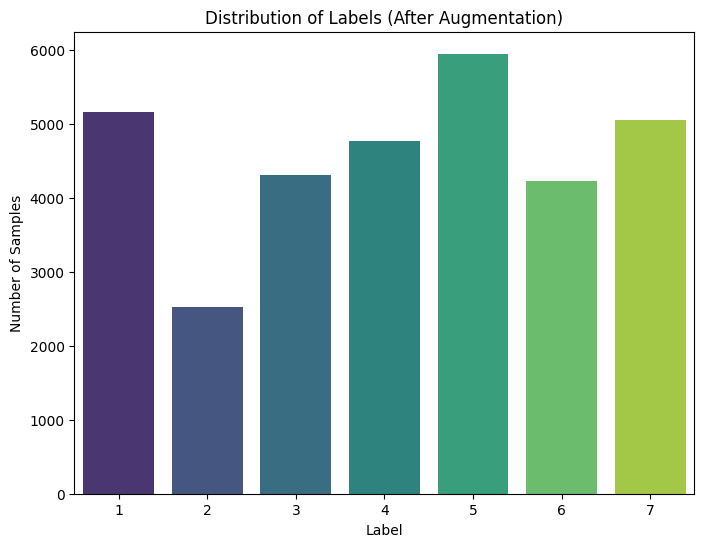

In [ ]:
from collections import Counter

label_counts = Counter(y_train)
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.title('Distribution of Labels (After Augmentation)')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()


KNN


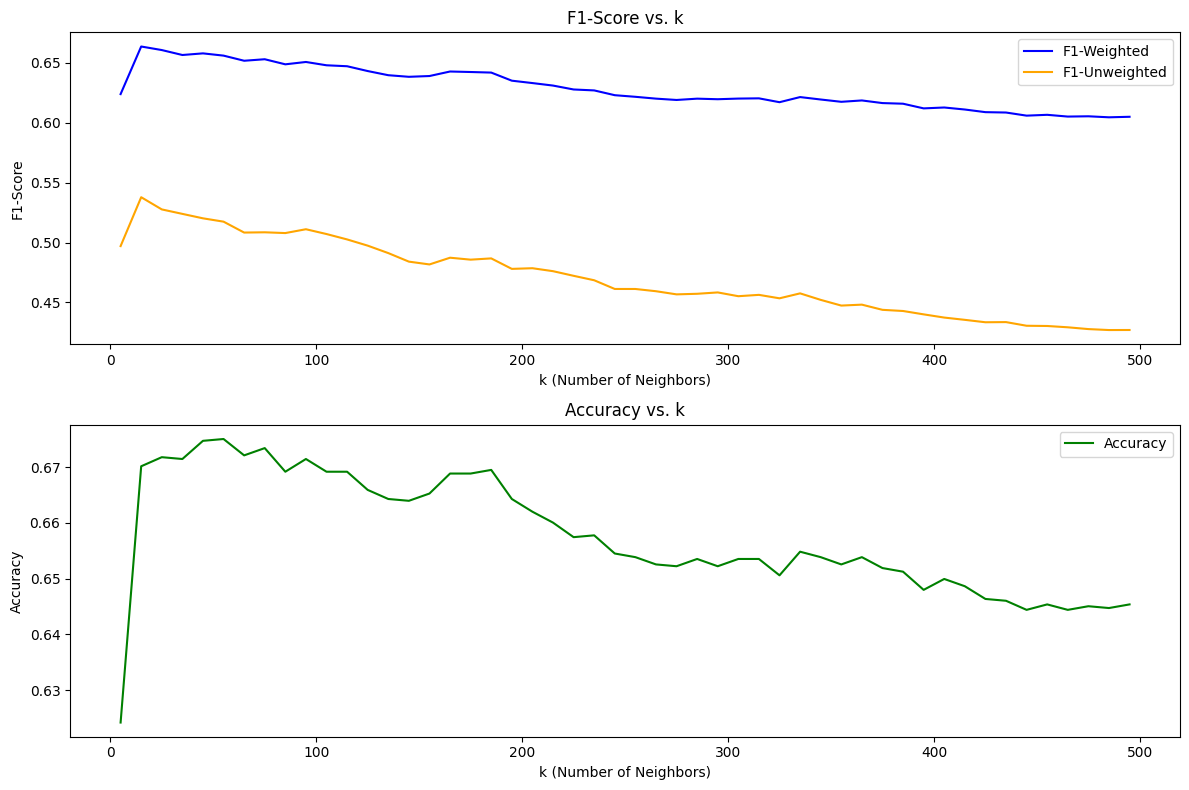

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

def evaluate_knn_k_range(X_train, y_train, X_test, y_test, k_start=5, k_end=500, step=10):
    k_values = list(range(k_start, k_end + 1, step))
    f1_scores_weighted = []
    f1_scores_unweighted = []
    accuracy_scores = []

    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train, y_train)

        # Dự đoán
        y_pred = knn_model.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        f1_scores_weighted.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
        f1_scores_unweighted.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

    return {
        'k_values': k_values,
        'accuracy': accuracy_scores,
        'f1_weighted': f1_scores_weighted,
        'f1_unweighted': f1_scores_unweighted
    }

def plot_knn_metrics(metrics):
    k_values = metrics['k_values']

    plt.figure(figsize=(12, 8))

    # Đồ thị F1-Score
    plt.subplot(2, 1, 1)
    plt.plot(k_values, metrics['f1_weighted'], label='F1-Weighted', color='blue')
    plt.plot(k_values, metrics['f1_unweighted'], label='F1-Unweighted', color='orange')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs. k')
    plt.legend()

    # Đồ thị Accuracy
    plt.subplot(2, 1, 2)
    plt.plot(k_values, metrics['accuracy'], label='Accuracy', color='green')
    plt.xlabel('k (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. k')
    plt.legend()

    plt.tight_layout()
    plt.show()

metrics_knn = evaluate_knn_k_range(X_train, y_train, X_test, y_test, k_start=5, k_end=500, step=10)

plot_knn_metrics(metrics_knn)

Train Set Evaluation:
              precision    recall  f1-score   support

           1       0.80      0.63      0.70      5160
           2       0.94      0.42      0.58      2529
           3       0.74      0.52      0.61      4302
           4       0.75      0.85      0.80      4772
           5       0.69      0.64      0.66      5946
           6       0.75      0.73      0.74      4230
           7       0.50      0.88      0.64      5048

    accuracy                           0.68     31987
   macro avg       0.74      0.67      0.68     31987
weighted avg       0.72      0.68      0.68     31987

Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.76      0.48      0.59       329
           2       0.95      0.27      0.42        74
           3       0.19      0.03      0.05       160
           4       0.84      0.86      0.85      1185
           5       0.61      0.47      0.53       478
           6       0.59      0.49  

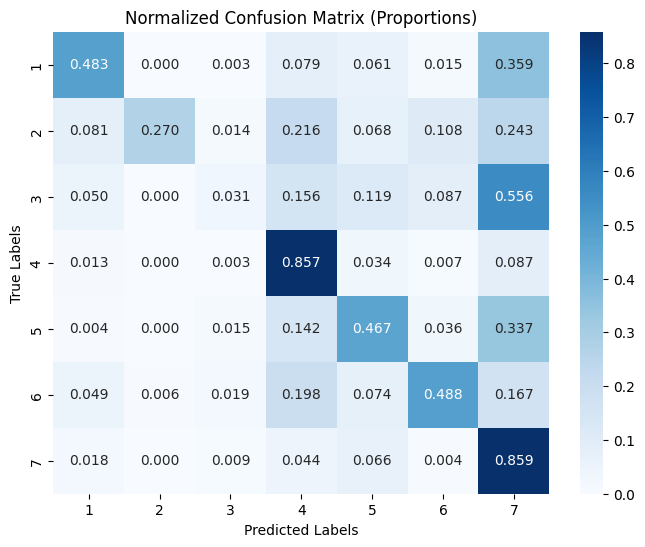

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=55))
knn_model.fit(X_train, y_train)

y_pred_train = knn_model.predict(X_train)
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train))
y_pred_test = knn_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()

In [ ]:
###Decision###

Best Parameters Found:
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}
Train Set Evaluation:
              precision    recall  f1-score   support

           1       0.77      0.83      0.80      5160
           2       0.72      0.69      0.70      2529
           3       0.77      0.77      0.77      4302
           4       0.85      0.82      0.84      4772
           5       0.82      0.80      0.81      5946
           6       0.83      0.77      0.80      4230
           7       0.78      0.82      0.80      5048

    accuracy                           0.80     31987
   macro avg       0.79      0.79      0.79     31987
weighted avg       0.80      0.80      0.80     31987

Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.33      0.36      0.34       329
           2       0.07      0.12      0.09        74
           3       0.10      0.20      0.14       160
           4       0.67      0.48 

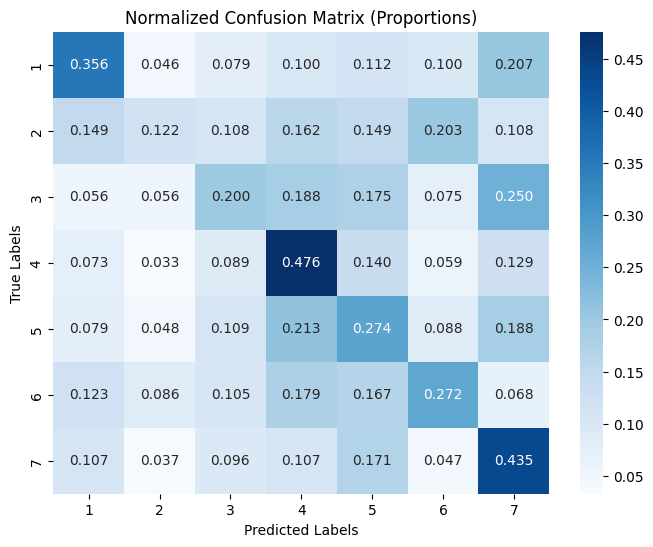

In [ ]:
# Grid Search
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_model = DecisionTreeClassifier(random_state=42)

# Tham số cho Grid Search
param_grid = {
    'criterion': ['gini'],
    'max_depth': [15, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

grid_search = GridSearchCV(tree_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters Found:")
print(grid_search.best_params_)

best_tree_model = grid_search.best_estimator_

y_pred_train = best_tree_model.predict(X_train)
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train))
y_pred_test = best_tree_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()


###Random Forest###

Train Set Evaluation:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      5160
           2       1.00      1.00      1.00      2529
           3       1.00      1.00      1.00      4302
           4       1.00      1.00      1.00      4772
           5       1.00      1.00      1.00      5946
           6       1.00      1.00      1.00      4230
           7       1.00      1.00      1.00      5048

    accuracy                           1.00     31987
   macro avg       1.00      1.00      1.00     31987
weighted avg       1.00      1.00      1.00     31987

Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.61      0.53      0.57       329
           2       0.91      0.14      0.24        74
           3       0.17      0.06      0.09       160
           4       0.80      0.81      0.81      1185
           5       0.49      0.35      0.41       478
           6       0.43      0.48  

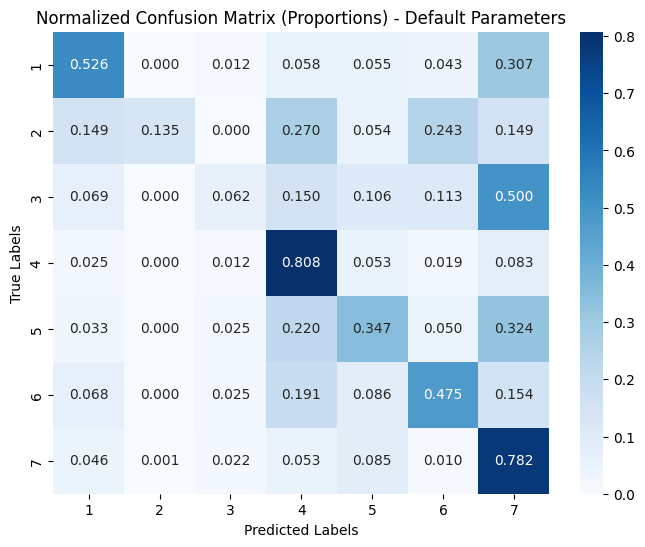

In [ ]:
# default param:
from sklearn.ensemble import RandomForestClassifier

rf_model_d = RandomForestClassifier(random_state=42)

rf_model_d.fit(X_train, y_train)

y_pred_train_default = rf_model_d.predict(X_train)
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train_default, zero_division=0))
y_pred_test_default = rf_model_d.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test_default, zero_division=0))

# Confusion Matrix
conf_matrix_default = confusion_matrix(y_test, y_pred_test_default, labels=np.unique(y_test))
conf_matrix_normalized_default = conf_matrix_default.astype('float') / conf_matrix_default.sum(axis=1)[:, np.newaxis]

# Vẽ Heatmap cho Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized_default, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions) - Default Parameters')
plt.show()


Logistic Regresion

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 500, 'logisticregression__penalty': 'l2'}
Best Cross-validation Score: 0.6087787697889654
Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.58      0.54      0.56       329
           2       0.28      0.35      0.31        74
           3       0.26      0.33      0.29       160
           4       0.84      0.81      0.83      1185
           5       0.57      0.56      0.56       478
           6       0.46      0.56      0.51       162
           7       0.63      0.61      0.62       680

    accuracy                           0.65      3068
   macro avg       0.52      0.54      0.53      3068
weighted avg       0.66      0.65      0.66      3068



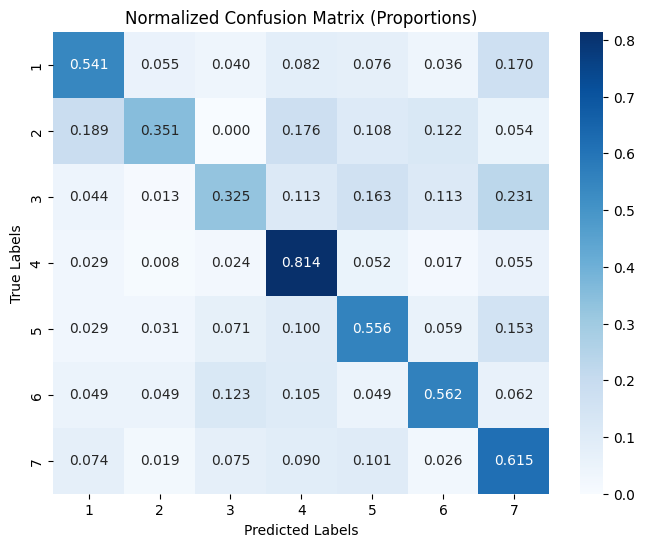

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42))

param_grid = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': ['l2'],
    'logisticregression__max_iter': [500, 1000]
}

grid_search = GridSearchCV(logreg_model, param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

y_pred_train = grid_search.predict(X_train)
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train))
y_pred_test = grid_search.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))


conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()


Train Set Evaluation:
              precision    recall  f1-score   support

           1       0.95      0.94      0.95      5160
           2       0.98      0.96      0.97      2529
           3       0.95      0.93      0.94      4302
           4       0.98      0.98      0.98      4772
           5       0.92      0.92      0.92      5946
           6       0.97      0.97      0.97      4230
           7       0.90      0.94      0.92      5048

    accuracy                           0.95     31987
   macro avg       0.95      0.95      0.95     31987
weighted avg       0.95      0.95      0.95     31987

Test Set Evaluation:
              precision    recall  f1-score   support

           1       0.58      0.54      0.56       329
           2       0.28      0.35      0.31        74
           3       0.26      0.33      0.29       160
           4       0.84      0.81      0.83      1185
           5       0.57      0.56      0.56       478
           6       0.46      0.56  

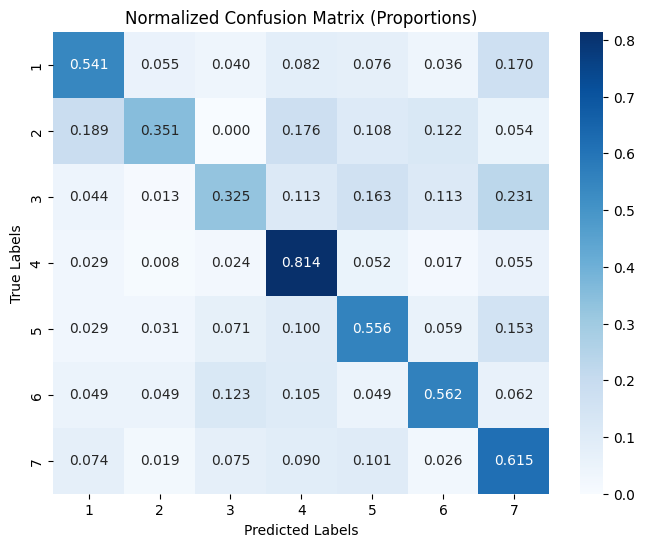

In [ ]:
logreg_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=500, solver='lbfgs',C=0.1,penalty='l2'))
# Huấn luyện
logreg_model.fit(X_train, y_train)

# Dự đoán nhãn
y_pred_train = logreg_model.predict(X_train)
print("Train Set Evaluation:")
print(classification_report(y_train, y_pred_train))
y_pred_test = logreg_model.predict(X_test)
print("Test Set Evaluation:")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()


SVM

<ipython-input-5-07630fce7c4b>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = train_data.groupby('label', group_keys=False).apply(


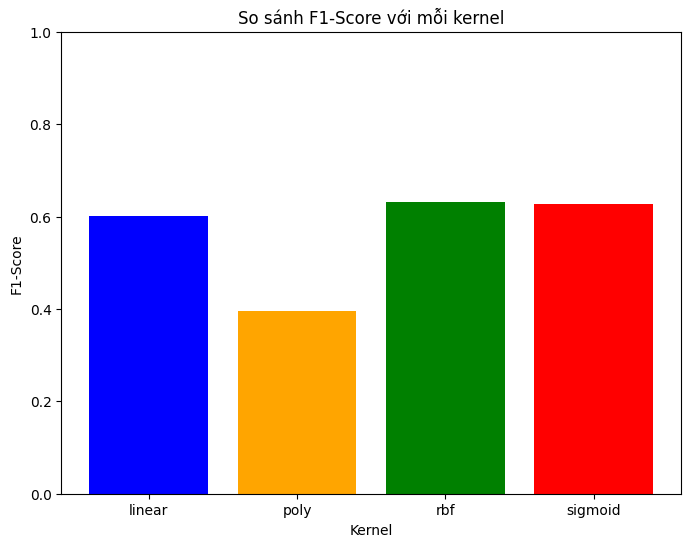

In [ ]:
D# khảo sát qua các kernel, với các params còn lại là mặc định
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report

train_data = pd.DataFrame(X_train)
train_data['label'] = y_train

balanced_data = train_data.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=300, random_state=42) if len(x) > 300 else x
)

X_train_balanced = balanced_data.drop('label', axis=1).values
y_train_balanced = balanced_data['label'].values

# Danh sách các kernel
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
f1_scores = []

for kernel in kernels:
    svm_model = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=1, gamma='scale'))
    svm_model.fit(X_train_balanced, y_train_balanced)
    y_pred_test = svm_model.predict(X_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')
    f1_scores.append(f1)

# so sánh F1-score
plt.figure(figsize=(8, 6))
plt.bar(kernels, f1_scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Kernel')
plt.ylabel('F1-Score')
plt.title('So sánh F1-Score với mỗi kernel')
plt.ylim(0, 1)
plt.show()


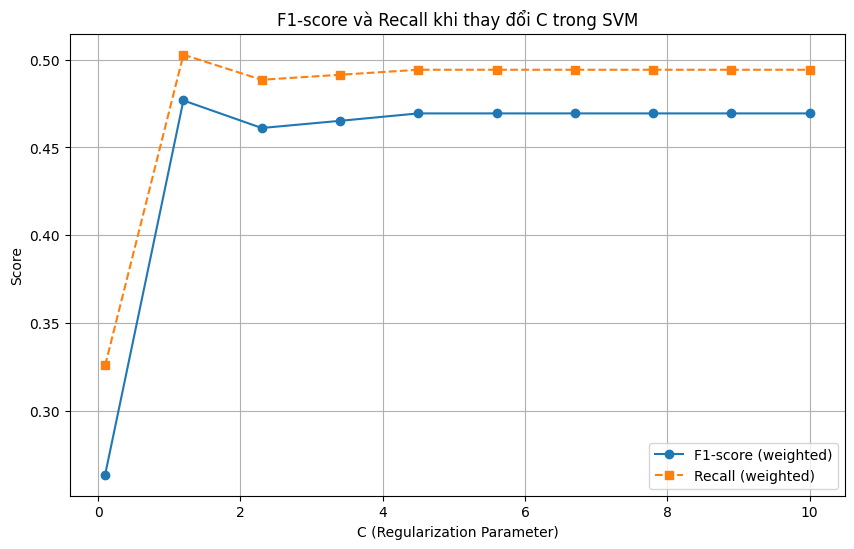

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, recall_score
from sklearn.utils import resample

def limit_samples(X, y, samples_per_label=500):
    X_limited = []
    y_limited = []
    unique_labels = np.unique(y)

    for label in unique_labels:
        X_label = X[y == label]
        y_label = y[y == label]
        X_resampled, y_resampled = resample(X_label, y_label,
                                            n_samples=min(samples_per_label, len(y_label)),
                                            random_state=42)
        X_limited.append(X_resampled)
        y_limited.append(y_resampled)

    X_limited = np.vstack(X_limited)
    y_limited = np.concatenate(y_limited)
    return X_limited, y_limited

X_train_limited, y_train_limited = limit_samples(X_train, y_train, samples_per_label=500)
X_test_limited, y_test_limited = limit_samples(X_test, y_test, samples_per_label=50)

C_values = np.linspace(0.1, 10, 10)
f1_scores = []
recall_scores = []

for C in C_values:
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=C, gamma='scale'))
    svm_model.fit(X_train_limited, y_train_limited)

    y_pred = svm_model.predict(X_test_limited)

    f1 = f1_score(y_test_limited, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test_limited, y_pred, average='weighted', zero_division=0)

    f1_scores.append(f1)
    recall_scores.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores, marker='o', label='F1-score (weighted)')
plt.plot(C_values, recall_scores, marker='s', label='Recall (weighted)', linestyle='--')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Score')
plt.title('F1-score và Recall khi thay đổi C trong SVM')
plt.legend()
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

           1       0.97      0.96      0.97      5160
           2       1.00      0.93      0.96      2529
           3       0.98      0.93      0.95      4302
           4       0.97      0.98      0.97      4772
           5       0.95      0.95      0.95      5946
           6       0.98      0.97      0.98      4230
           7       0.89      0.98      0.93      5048

    accuracy                           0.96     31987
   macro avg       0.96      0.96      0.96     31987
weighted avg       0.96      0.96      0.96     31987

              precision    recall  f1-score   support

           1       0.70      0.67      0.68       329
           2       0.71      0.36      0.48        74
           3       0.41      0.30      0.35       160
           4       0.90      0.87      0.88      1185
           5       0.67      0.67      0.67       478
           6       0.66      0.63      0.65       162
           7       0.67 

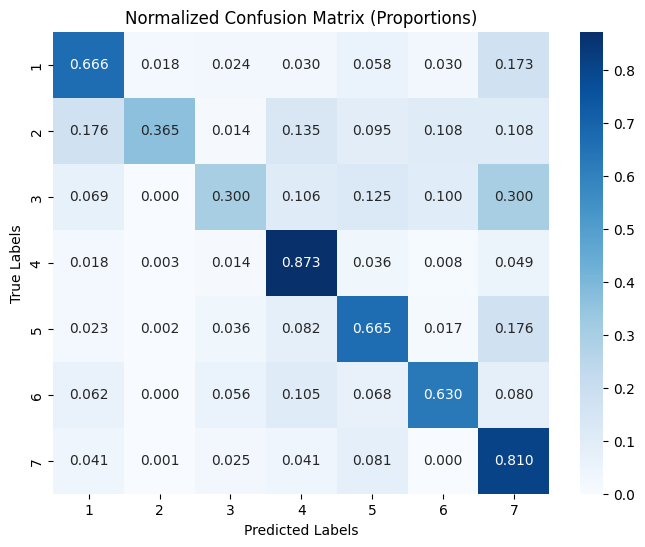

In [ ]:
# C=1
from sklearn.svm import SVC
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale'))

svm_model.fit(X_train, y_train)

y_pred_train = svm_model.predict(X_train)
print(classification_report(y_train, y_pred_train))

y_pred_test = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()

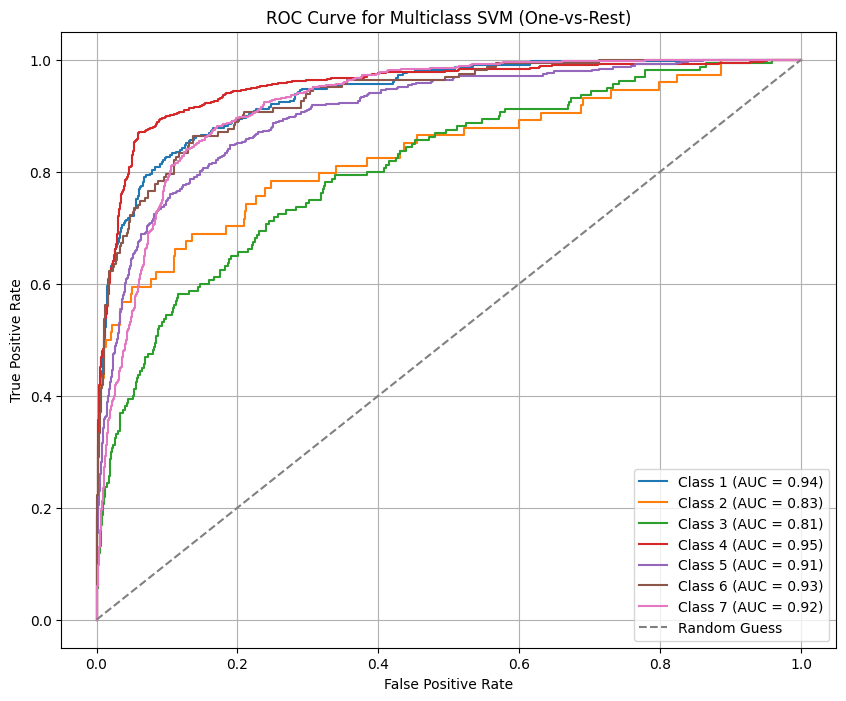

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import joblib

import os
model_path = os.path.join('/content/drive/My Drive',
                          f'svm_model_0.7516_size100.joblib')
loaded_model = joblib.load(model_path)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

y_scores = loaded_model.decision_function(X_test)

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multiclass SVM (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
## dump mô hình lại
# from google.colab import drive
# drive.mount('/content/drive')
# import joblib

# import os
# model_path = os.path.join('/content/drive/My Drive',
#                           f'svm_model_{accuracy_score(y_pred_test, y_test):.4f}_size{size}.joblib')
# joblib.dump(svm_model, model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/My Drive/svm_model_0.7516_size100.joblib']

Cross-Validation Accuracy: 0.784 ± 0.004

Classification Report (Cross-Validation on Training Data):
              precision    recall  f1-score   support

           1       0.80      0.78      0.79      5160
           2       0.92      0.70      0.79      2529
           3       0.81      0.73      0.77      4302
           4       0.85      0.86      0.86      4772
           5       0.74      0.74      0.74      5946
           6       0.87      0.84      0.85      4230
           7       0.65      0.82      0.72      5048

    accuracy                           0.78     31987
   macro avg       0.81      0.78      0.79     31987
weighted avg       0.79      0.78      0.79     31987


Classification Report (Test Data):
              precision    recall  f1-score   support

           1       0.70      0.67      0.68       329
           2       0.71      0.36      0.48        74
           3       0.41      0.30      0.35       160
           4       0.90      0.87      0.88      

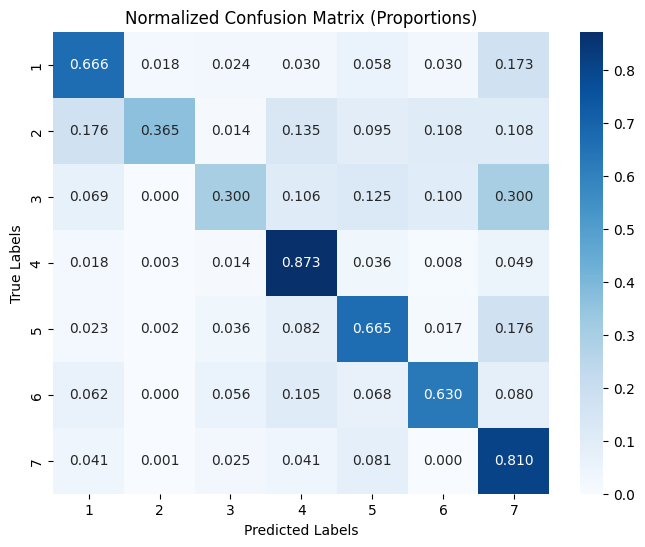

In [ ]:
# Evaluation với C=1, kernel dùng RBF
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import  ConfusionMatrixDisplay

svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1, gamma='scale'))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá mô hình
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Dự đoán nhãn
y_pred_cv = cross_val_predict(svm_model, X_train, y_train, cv=cv)

print("\nClassification Report (Cross-Validation on Training Data):")
print(classification_report(y_train, y_pred_cv))

# Train mô hình
svm_model.fit(X_train, y_train)

y_pred_test = svm_model.predict(X_test)
print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix (Proportions)')
plt.show()

In [ ]:
Conclusion

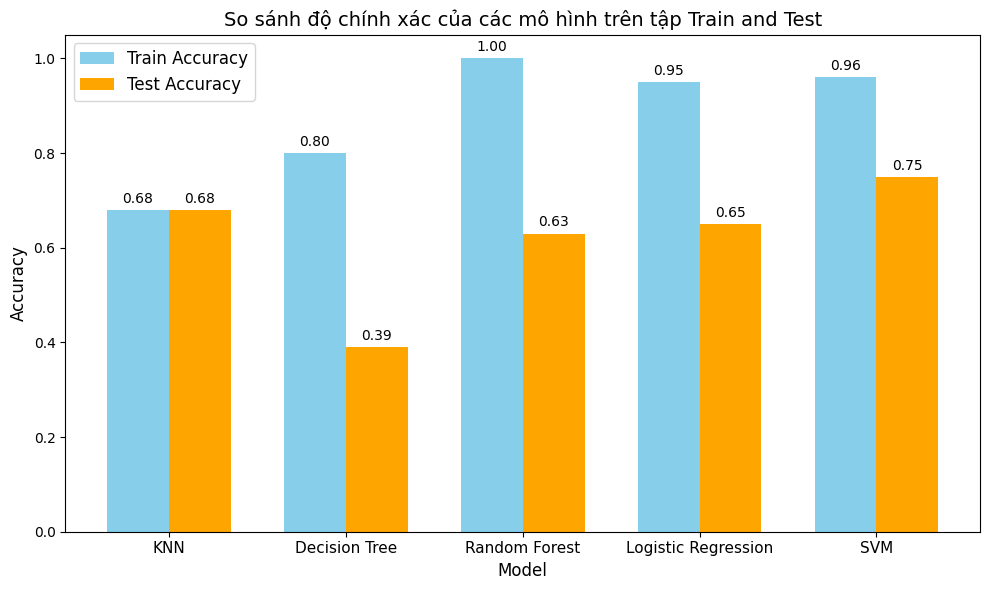

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['KNN', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SVM']
train_acc_m = [0.68, 0.80, 1.00, 0.95, 0.96]
test_acc_m = [0.68, 0.39, 0.63, 0.65, 0.75]

x = np.arange(len(model))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width / 2, train_acc_m, width, label='Train Accuracy', color='skyblue')
bars2 = ax.bar(x + width / 2, test_acc_m, width, label='Test Accuracy', color='orange')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('So sánh độ chính xác của các mô hình trên tập Train and Test', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model, fontsize=11)
ax.legend(fontsize=12)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
